In [28]:
import os
from qiskit import execute
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit

from quantuminspire.credentials import get_authentication
from quantuminspire.qiskit import QI

QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')

import re

<a id="layout"></a>
# 1. Quantum Key Distribution Activity layout

In project, we are going to implement the E91 protocol. Steps of the protocol:

1. Create entangled states
2. Alice randomly selects a basis ( × or + )
3. Bob randomly selects a basis ( × or + )
4. `Intermediate interface function 1`: a MUX that creates a circuit based on Alice and Bob's selection of bases
5. `Intermediate interface function 2`: execute the measurement on Quantum Inspire 
6. `Intermediate interface function 3`: send back measurement results to Alice and Bob
7. `ANNOUNCE BASIS`: Alice announces which basis she used to encode each bit, via the classical channel.

7. `FIND SYMMETRIC KEY`: Alice and Bob discard bits in their key that used a different basis.

These 7 steps allow a key to be distributed between Alice and Bob securely, now the two can send secure and encrypted messages through an insecure channel. In the required content for this lab, we will implement steps 1-4, and in the optional content we will implement steps 5-7.

Note that we have left out **Step8: Analysis** here. In this lab, we will not worry about an eavesdropper, but focus on the code for the basic protocol. Therefore, Alice and Bob don't need to run an analysis step. If you're interested, you can try implementing code for Eve in the optional challenge section at the end of the notebook!

In [42]:
import numpy as np
import random

In [95]:
# Parameters
N_en_pairs = 10
alice_seq = [random.randint(1, 3) for i in range(N_en_pairs)]
bob_seq = [random.randint(1, 3) for i in range(N_en_pairs)]

<a id="layout"></a>
## 1. Create entangled states

In [96]:
Quantum_Circuit = []

for i in range(N_en_pairs):
    # Create an entangled pair for Alice and Bob in each loop
    Alice_Reg = QuantumRegister(1, name="alice")
    Bob_Reg = QuantumRegister(1, name="bob")
    cr = ClassicalRegister(2, name="cr")
    qc = QuantumCircuit(Alice_Reg, Bob_Reg, cr)
    
    # Entanglement operation
    qc.x(Alice_Reg)
    qc.x(Bob_Reg)
    qc.h(Alice_Reg)
    qc.cx(Alice_Reg, Bob_Reg)
    
    # Cicuit Measurement for different bases
    
    if alice_seq[i]== 1:            #If Alice's random sequence is 1, Alice measures in the Z basis
        qc.measure(Alice_Reg,cr[0])  
    elif alice_seq[i] == 2:         #If Alice's random sequence is 2, Alice measures in the X basis
        qc.h(Alice_Reg)
        qc.measure(Alice_Reg,cr[0])
    elif alice_seq==3:              #If Alice's random sequence is 3, Alice measures in the V basis (-1/sqrt(2), 0, 1/sqrt(2))
        qc.s(Alice_Reg)
        qc.h(Alice_Reg)
        qc.tdg(Alice_Reg)
        qc.h(Alice_Reg)
        qc.measure(Alice_Reg, cr[0])
        
    if bob_seq[i]==1:               #If  Bob's random sequence is 1, Bob measures in the -W basis
        qc.h(Bob_Reg)
        qc.tdg(Bob_Reg)
        qc.h(Bob_Reg)
        qc.sdg(Bob_Reg)
        qc.measure(Bob_Reg, cr[1])
    elif bob_seq[i] == 2:           #If  Bob's random sequence is 2, Bob measures in the V basis
        qc.s(Bob_Reg)
        qc.h(Bob_Reg)
        qc.tdg(Bob_Reg)
        qc.h(Bob_Reg)
        qc.measure(Bob_Reg, cr[1])
    elif bob_seq[i] == 3:           #If  Bob's random sequence is 3, Bob measures in the X basis
        qc.h(Bob_Reg)
        qc.measure(Bob_Reg, cr[1])

    
    Quantum_Circuit.append(qc)
    #for i in range(N_en_pairs):
    #qc.h(Alice_Reg[i])
    #qc.cx(Alice_Reg[i], Bob_Reg[i])
#Quantum_Circuit.draw(output='mpl')
#Quantum_Circuit

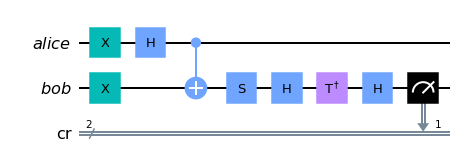

In [97]:
Quantum_Circuit[0].draw(output='mpl')


In [98]:
from quantuminspire.credentials import save_account
save_account('64a63b0e608f63c8b7f9a7695a23f3f02bdabd9e')
project_name = 'E91_test'
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL, project_name=project_name)
# Create an interface between Qiskit and Quantum Inpsire to execute the circuit
qi_backend = QI.get_backend('QX single-node simulator')
job = execute(Quantum_Circuit, qi_backend, shots =1)

In [99]:
results = job.result()
counts = results.get_counts()

In [100]:
counts[0]

{'10': 1}

In [101]:
abPatterns = [
    re.compile('00'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
    re.compile('01'), # search for the '..01' output
    re.compile('10'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
    re.compile('11')  # search for the '..11' output
]

In [102]:
aliceResults = [] # Alice's results (string a)
bobResults = [] # Bob's results (string a')

for i in range(N_en_pairs):

    res = list(counts[i].keys())[0] # extract the key from the dict and transform it to str; execution result of the i-th circuit
    
    if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(-1) # Bob got the result -1
    if abPatterns[1].search(res):
        aliceResults.append(1)
        bobResults.append(-1)
    if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(1) # Bob got the result 1
    if abPatterns[3].search(res): 
        aliceResults.append(1)
        bobResults.append(1)

In [103]:
aliceKey = [] # Alice's key string k
bobKey = [] # Bob's key string k'

# comparing the strings with measurement choices
for i in range(N_en_pairs):
    # if Alice and Bob have measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
    if (alice_seq[i] == 2 and bob_seq[i] == 1) or (alice_seq[i] == 3 and bob_seq[i] == 2):
        aliceKey.append(aliceResults[i]) # record the i-th result obtained by Alice as the bit of the secret key k
        bobKey.append(- bobResults[i]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
        
keyLength = len(aliceKey) # length of the secret key

In [104]:
abKeyMismatches = 0 # number of mismatching bits in Alice's and Bob's keys

for j in range(keyLength):
    if aliceKey[j] != bobKey[j]:
        abKeyMismatches += 1

In [105]:
aliceKey

[-1, 1]

In [106]:
abKeyMismatches

1